# Projet de fin d'étude - Parties finales (catégorisation/classification client - prédiction (ML))
## Camille Bouberka - Armand Dusart - Jules Enguehard
## encadrant : Martin Nasse
## 2020-2021 - ESME Sudria 

# 3 - Catégorisation des produits

In [1]:
from pandas import read_csv
from pandas import unique
df = read_csv(r'C:\Users\arman\Desktop\data\Online_Retail_traitement.csv',sep=";")
description = unique(df['Description'])
description[0]

'WHITE HANGING HEART T-LIGHT HOLDER'

On souhaite désormais catégoriser les produits.
Comme on peut le remarquer ci-dessus, la colonnes Description nécessitent l'utilisation de méthode NLP avant de pouvoir être catégorisé. 

## 3.1 - Preprocesing

In [2]:
#On définit les stopwords = stopword en anglais + couleurs + certains mots trop récurrents
from nltk.corpus import stopwords
from matplotlib.colors import get_named_colors_mapping

stop_words = stopwords.words('english') + ['manual','discount','postage','set','pack'] + [color.split(':')[1] for color in get_named_colors_mapping() if 'xkcd' in color]

In [3]:
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

def preprocessing_description(x,opt,stop_words): 
    # Convertir le texte en minuscule
    x = x.lower()
    # supprimer les digits 
    x =re.sub('\d+', '', x)
    # Supprimer les ponctuations (? ! etc...) --> Chaque caractère de ponctuation sera remplacé par un espace ' ' 
    x = x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    # remove all single characters
    x =re.sub(r'\s+[a-zA-Z]\s+', ' ',x)
    #choice option (lem or stem or nothing)
    if opt == "lem" :
        WNlemmatizer = WordNetLemmatizer()
        x = [WNlemmatizer.lemmatize(token.lower()) for token in word_tokenize(x) if token.lower() not in stop_words and len(token) > 1] 
    elif opt == "stem" :
        Porterstemmer = PorterStemmer()
        x =[Porterstemmer.stem(token.lower()) for token in word_tokenize(x) if token not in stop_words and len(token) > 1]
    else :
        x = [token for token in word_tokenize(x) if token not in stop_words and len(token) > 2]
    if len(x) < 1 :
        x = None
    return x

#On souhaite classifier selon le sens des mots alors nous allons utiliser la technique de Lemmatization 
#afin de garder la définition des mots
description_prepro =  [preprocessing_description(x,"lem",stop_words) for x in description if preprocessing_description(x,"lem",stop_words) != None]

## 3.2 - Observations

In [4]:
print("Nombre de descriptions différentes : ", len(unique([" ".join(desc) for desc in description_prepro])))

Nombre de descriptions différentes :  3283


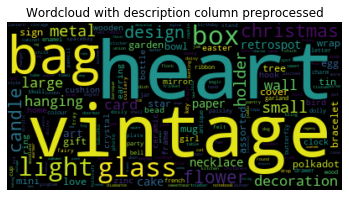

In [5]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud(description_prepro): 
        freq = Counter([word for desc in description_prepro for word in desc])
        wordcloud = WordCloud().generate_from_frequencies(freq)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("Wordcloud with description column preprocessed")
        plt.show()
        
wordcloud(description_prepro)      

In [6]:
print("Description non-traitée : ",description[0])
print("Description traitée : ",description_prepro[0])

Description non-traitée :  WHITE HANGING HEART T-LIGHT HOLDER
Description traitée :  ['hanging', 'heart', 'light', 'holder']


## 3.3 - Topic-modelling

Nous allons utiliser LDA pour générer des sujets/thèmes aux descriptions

In [7]:
from gensim.corpora import Dictionary
# Création du dictionnaire
dictionary = Dictionary(description_prepro)
print("Taille du vocabulaire : ",dictionary.num_nnz)
# moins de 15 documents (nombre absolu) ou
# plus de 0,5 document (fraction de la taille totale du corpus, pas de nombre absolu).
# après les deux étapes ci-dessus, ne gardez que les 100000 premiers jetons les plus fréquents.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=13000)
# Fréquence et répartition des mots dans les descriptions
bow_corpus = [dictionary.doc2bow(doc) for doc in description_prepro]

Taille du vocabulaire :  13392


In [8]:
from gensim import corpora, models
# Initialisation du model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
num_topic= 5
print("lda...")
lda_model = models.LdaMulticore(bow_corpus, num_topics=num_topic, id2word=dictionary, passes=2, workers=2)
print("lda tf-idf...")
lda_model_tfidf = models.LdaMulticore(corpus_tfidf, num_topics=num_topic, id2word=dictionary, passes=2, workers=4)
print("init")

lda...
lda tf-idf...
init


In [9]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.044*"small" + 0.038*"box" + 0.024*"bowl" + 0.024*"easter" + 0.023*"polkadot" + 0.022*"mirror" + 0.021*"design" + 0.021*"gift" + 0.020*"skull" + 0.020*"mug"
Topic: 1 
Words: 0.070*"heart" + 0.048*"decoration" + 0.038*"tin" + 0.031*"design" + 0.029*"star" + 0.028*"home" + 0.026*"large" + 0.022*"vintage" + 0.022*"earring" + 0.021*"zinc"
Topic: 2 
Words: 0.052*"candle" + 0.047*"metal" + 0.039*"paper" + 0.035*"sign" + 0.034*"box" + 0.023*"bracelet" + 0.023*"vintage" + 0.022*"hook" + 0.020*"cover" + 0.019*"ribbon"
Topic: 3 
Words: 0.072*"vintage" + 0.069*"bag" + 0.037*"christmas" + 0.037*"card" + 0.029*"flower" + 0.028*"glass" + 0.028*"heart" + 0.022*"tree" + 0.019*"garden" + 0.017*"mug"
Topic: 4 
Words: 0.066*"light" + 0.045*"holder" + 0.043*"glass" + 0.042*"necklace" + 0.037*"wall" + 0.037*"heart" + 0.030*"art" + 0.026*"cake" + 0.021*"retrospot" + 0.020*"hanging"


In [10]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.042*"vintage" + 0.041*"wrap" + 0.035*"candle" + 0.030*"heart" + 0.029*"retrospot" + 0.023*"metal" + 0.022*"plate" + 0.022*"pantry" + 0.019*"cutlery" + 0.019*"design"
Topic: 1 Word: 0.038*"card" + 0.037*"flower" + 0.029*"art" + 0.027*"decoration" + 0.027*"christmas" + 0.027*"wall" + 0.023*"cover" + 0.022*"garden" + 0.021*"large" + 0.020*"hanging"
Topic: 2 Word: 0.053*"box" + 0.038*"design" + 0.034*"necklace" + 0.033*"glass" + 0.026*"paper" + 0.024*"candle" + 0.022*"bird" + 0.022*"earring" + 0.021*"holder" + 0.021*"colour"
Topic: 3 Word: 0.032*"mug" + 0.032*"frame" + 0.028*"mirror" + 0.026*"cup" + 0.025*"glass" + 0.024*"sticker" + 0.024*"heart" + 0.022*"photo" + 0.019*"bowl" + 0.019*"doormat"
Topic: 4 Word: 0.060*"light" + 0.042*"bag" + 0.032*"small" + 0.031*"holder" + 0.030*"tin" + 0.029*"polkadot" + 0.025*"ribbon" + 0.024*"metal" + 0.023*"sign" + 0.021*"heart"


In [11]:
x = 'dolls red'
bow_vector = dictionary.doc2bow(preprocessing_description(x,"lem",stop_words))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.20000000298023224	 Topic: 0.044*"small" + 0.038*"box" + 0.024*"bowl" + 0.024*"easter" + 0.023*"polkadot"
Score: 0.20000000298023224	 Topic: 0.070*"heart" + 0.048*"decoration" + 0.038*"tin" + 0.031*"design" + 0.029*"star"
Score: 0.20000000298023224	 Topic: 0.052*"candle" + 0.047*"metal" + 0.039*"paper" + 0.035*"sign" + 0.034*"box"
Score: 0.20000000298023224	 Topic: 0.072*"vintage" + 0.069*"bag" + 0.037*"christmas" + 0.037*"card" + 0.029*"flower"
Score: 0.20000000298023224	 Topic: 0.066*"light" + 0.045*"holder" + 0.043*"glass" + 0.042*"necklace" + 0.037*"wall"


## 3.4 - Clustering

Les résultats des LDA n'êtant pas satisfaisant, nous avons opté pour une clusterisation par une vectorisation Bert (le sens des mots)
<p> Nous allons regrouper les descriptions par leur sens en utilisant bert au lieu de LDA 

In [12]:
from sklearn.cluster import KMeans
def critere_coude(df,start=5,end=100,step=5):
    vector = df
    Inertie =[]
    score_list = []
    for i in range(start,end,step):
        kmeans = KMeans(n_clusters=i, max_iter=1000, n_init=1).fit(vector)
        preds = kmeans.fit_predict(vector)
        score = silhouette_score(vector, preds)
        print("For n_clusters =", i, "The average silhouette_score is :", score)
        Inertie.append(kmeans.inertia_)
        score_list.append((score,i))
    plt.plot(range(start, end), Inertie)
    plt.title('Critere de Coude')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertie')
    plt.show()
    print('best score is : ',max([score[0] for score in score_list ]), 'For ',[score[1] for score in score_list if score[0] == max([score[0] for score in score_list ])],' clusters')

In [13]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import  PCA
def silhouette_score_describe(X,start=5,end=100,step=5):
    range_n_clusters = range(start,end,step)
    
    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")   
        ax1.set_yticks([])  
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        
        
        transformer = PCA(n_components=2)
        X = transformer.fit_transform(X)
        
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')    
        centers = clusterer.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')
        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')   
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")
    
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
    plt.show()

Afin de déterminer le nombre de cluster idéal, on utilise 2 méthodes :
<p style="color:#CB4919;">le critère de coude et le silhouette_score

In [14]:
from sent2vec.vectorizer import Vectorizer

vectorizer = Vectorizer()
vectorizer.bert(description_prepro)
x = vectorizer.vectors


For n_clusters = 2 The average silhouette_score is : 0.368136
For n_clusters = 3 The average silhouette_score is : 0.25267333
For n_clusters = 4 The average silhouette_score is : 0.13930956
For n_clusters = 5 The average silhouette_score is : 0.10170324
For n_clusters = 6 The average silhouette_score is : 0.17231858
For n_clusters = 7 The average silhouette_score is : 0.08705365
For n_clusters = 8 The average silhouette_score is : 0.08720093
For n_clusters = 9 The average silhouette_score is : 0.078621976


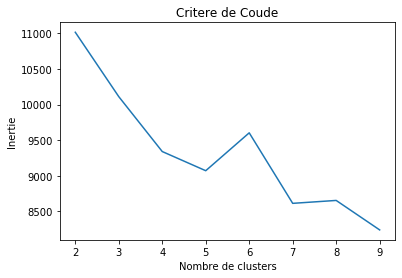

best score is :  0.368136 For  [2]  clusters
For n_clusters = 2 The average silhouette_score is : 0.368136
For n_clusters = 3 The average silhouette_score is : 0.5512918
For n_clusters = 4 The average silhouette_score is : 0.4299092
For n_clusters = 5 The average silhouette_score is : 0.3903418
For n_clusters = 6 The average silhouette_score is : 0.39022666
For n_clusters = 7 The average silhouette_score is : 0.35816103
For n_clusters = 8 The average silhouette_score is : 0.35976502
For n_clusters = 9 The average silhouette_score is : 0.36428308


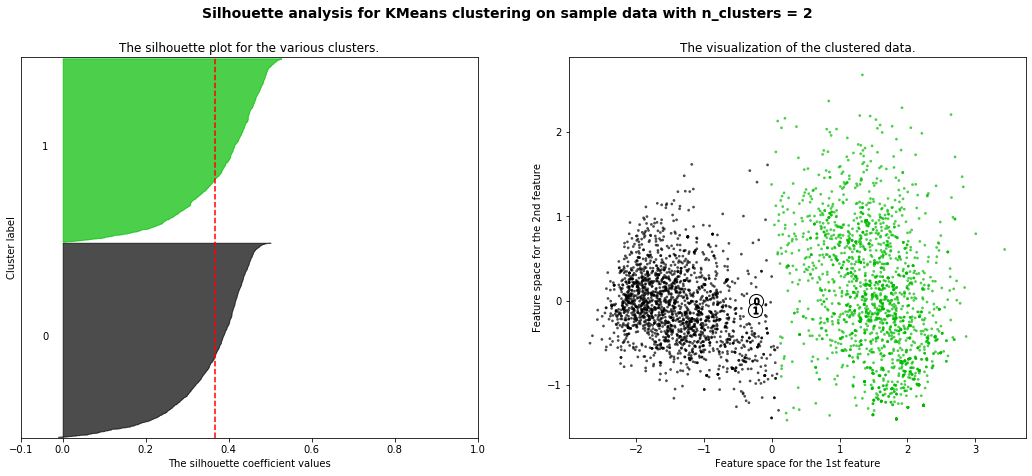

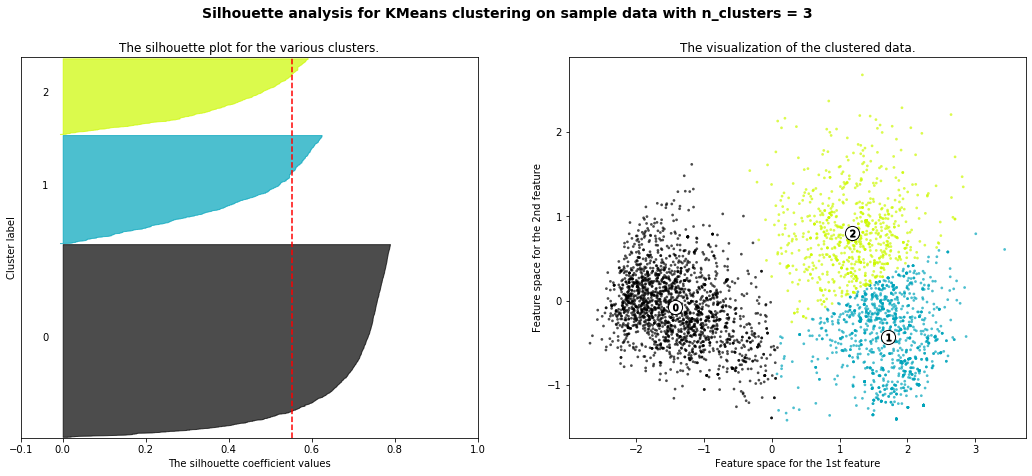

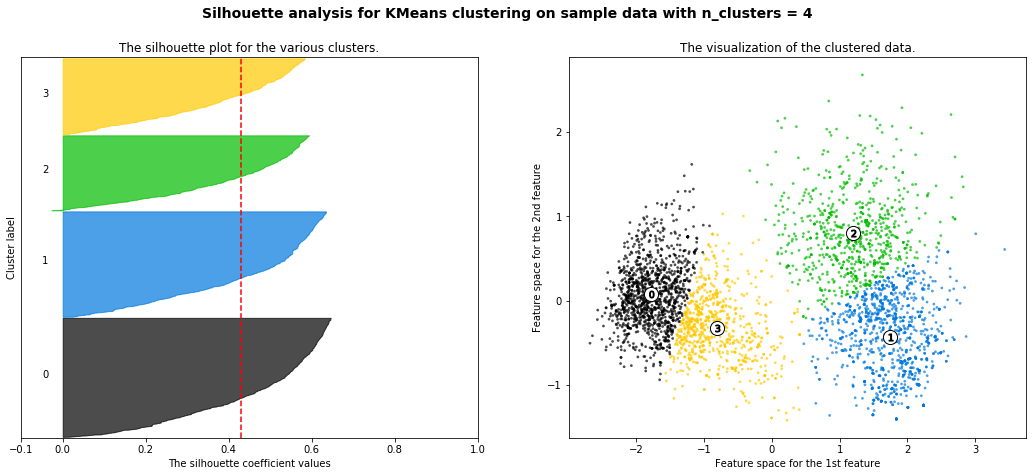

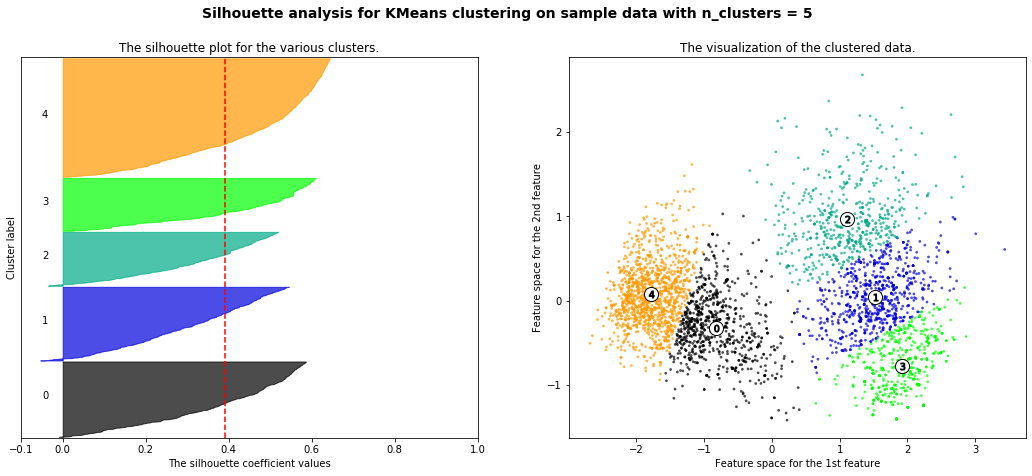

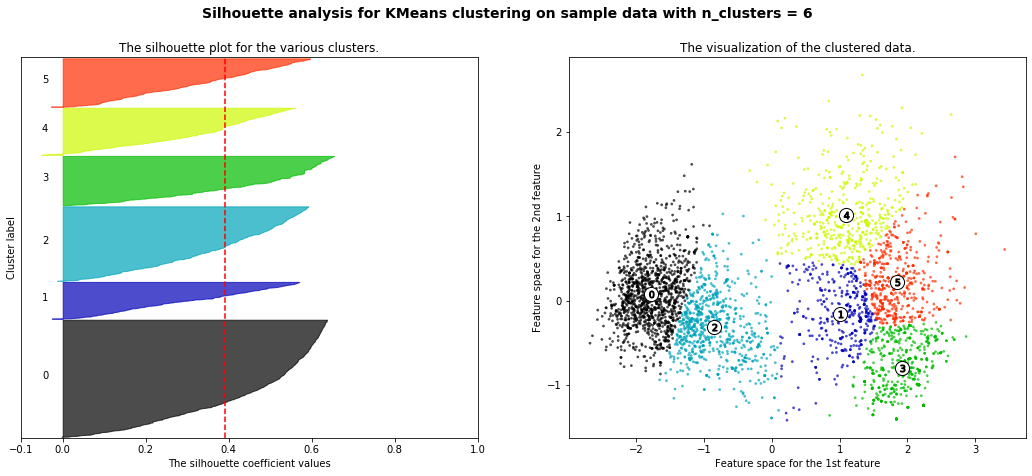

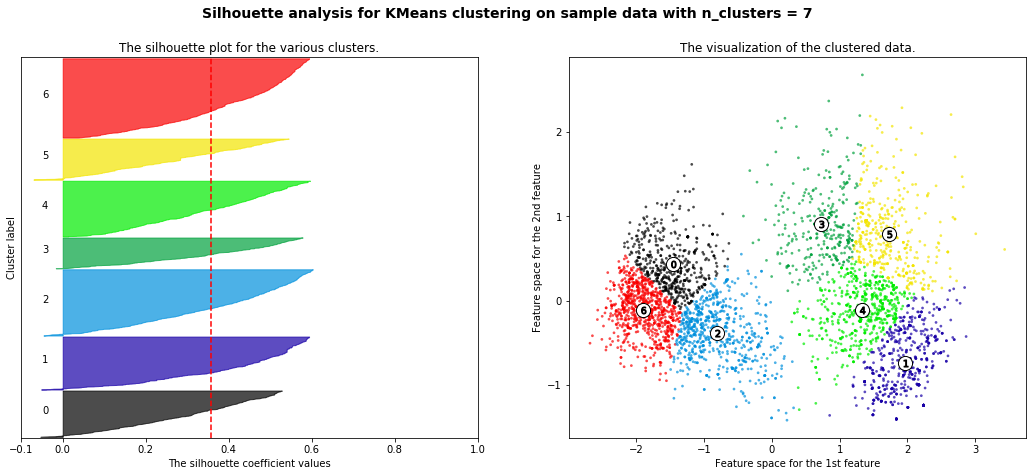

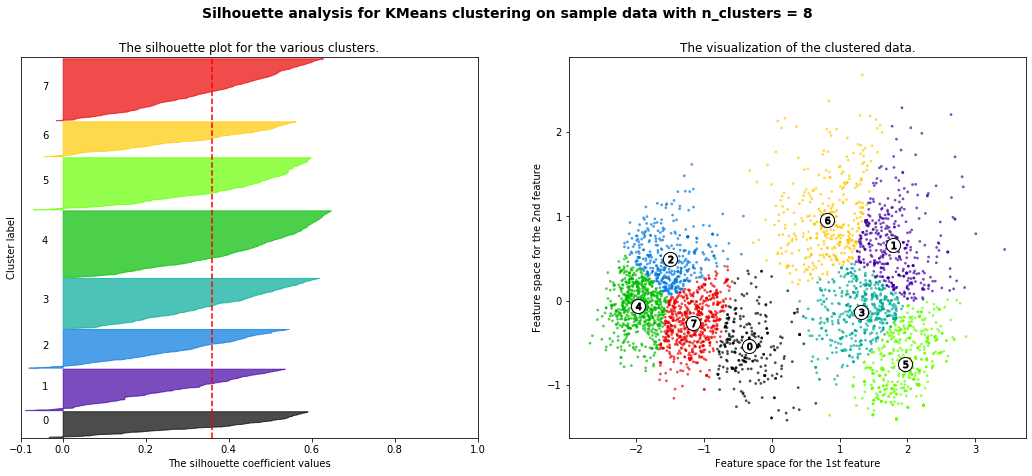

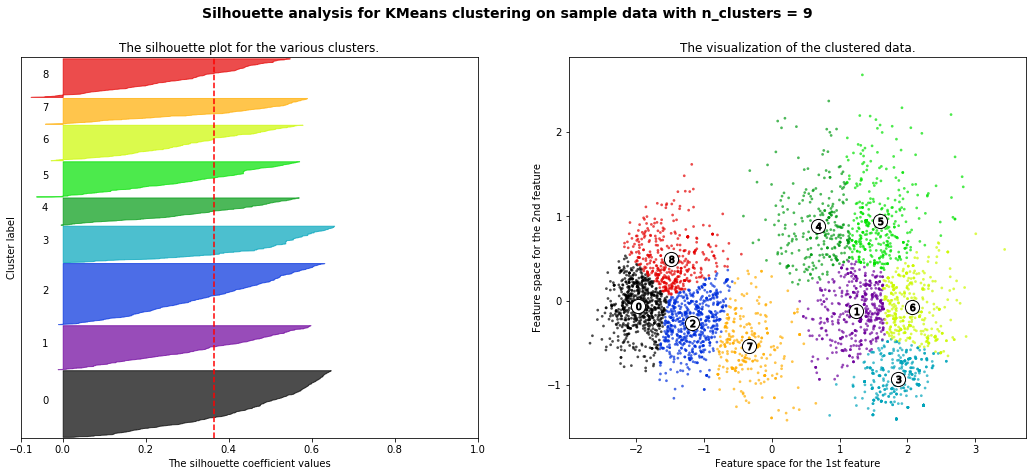

In [15]:
critere_coude(x,start=2,end=10,step=1)
silhouette_score_describe(x,start=2,end=10,step=1)

<p style="color:#CB4919;">D'après les resultats du critère de coude, le nombre de clusters idéal est 4 et cela se confirme avec le silhouette_score

In [16]:
kmeans = KMeans(n_clusters = 4, random_state = 42)
kmeans.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [17]:
from pandas import DataFrame
df_predict = DataFrame(columns=['Description','Catégorie'])
df_predict['Description'] = description_prepro
df_predict['Catégorie'] = kmeans.predict(x)
df_predict

,Description,Catégorie
0,"[hanging, heart, light, holder]",3
1,"[metal, lantern]",3
2,"[cupid, heart, coat, hanger]",2
3,"[knitted, union, flag, hot, water, bottle]",0
4,"[woolly, hottie, heart]",2
...,...,...
3869,"[letter, bling, key, ring]",0
3870,"[letter, bling, key, ring]",0
3871,"[letter, bling, key, ring]",0
3872,"[crystal, skull, phone, charm]",1


Création de colonnes résultantes des catégories

In [18]:
for i in range(4) :
    df_predict[str(i)] = df_predict.apply(lambda _: 1 if i ==  _.Catégorie else None, axis=1)

In [19]:
freq = [] 
df_predict = df_predict.set_index("Description")
for i in range(4):
    freq.append(Counter([word for desc in df_predict[str(i)].dropna().index for word in desc]).most_common())
df_counter = DataFrame(index=["catégorie "+str(i) for i in range(4)], data=freq)

Répartitions des descriptions (unique) par catégories

In [20]:
df_predict.count()

Catégorie    3874
0             917
1            1051
2             955
3             951
dtype: int64

In [21]:
df_predict.head(10)

,Catégorie,0,1,2,3
Description,,,,,
"[hanging, heart, light, holder]",3,NaN,NaN,NaN,1.0
"[metal, lantern]",3,NaN,NaN,NaN,1.0
"[cupid, heart, coat, hanger]",2,NaN,NaN,1.0,NaN
"[knitted, union, flag, hot, water, bottle]",0,1.0,NaN,NaN,NaN
"[woolly, hottie, heart]",2,NaN,NaN,1.0,NaN
"[babushka, nesting, box]",2,NaN,NaN,1.0,NaN
"[glass, star, frosted, light, holder]",0,1.0,NaN,NaN,NaN
"[hand, warmer, union, jack]",1,NaN,1.0,NaN,NaN
"[assorted, colour, bird, ornament]",2,NaN,NaN,1.0,NaN


In [22]:
df_counter

,0,1,2,3,4,5,6,7,8,9,...,904,905,906,907,908,909,910,911,912,913
catégorie 0,"(glass, 86)","(box, 61)","(heart, 61)","(vintage, 59)","(bag, 57)","(design, 49)","(small, 46)","(flower, 41)","(large, 38)","(retrospot, 34)",...,"(notting, 1)","(hill, 1)","(naught, 1)","(cross, 1)","(jet, 1)","(crome, 1)","(sunglass, 1)","(blank, 1)","(puncture, 1)","(repair, 1)"
catégorie 1,"(vintage, 112)","(heart, 85)","(christmas, 62)","(metal, 58)","(box, 56)","(decoration, 54)","(hanging, 53)","(holder, 52)","(wall, 51)","(light, 50)",...,None,None,None,None,None,None,None,None,None,None
catégorie 2,"(retrospot, 62)","(polkadot, 59)","(heart, 49)","(vintage, 40)","(bag, 37)","(candle, 33)","(necklace, 29)","(spaceboy, 26)","(tin, 26)","(assorted, 25)",...,None,None,None,None,None,None,None,None,None,None
catégorie 3,"(heart, 73)","(candle, 56)","(light, 47)","(flower, 39)","(card, 35)","(wrap, 33)","(christmas, 32)","(metal, 30)","(holder, 28)","(decoration, 28)",...,None,None,None,None,None,None,None,None,None,None


In [23]:
catégories = {0:"Contenants",1:"Cadeaux pour evenements",2:"Objets artistiques",3:"Objets de creation"}
df_predict['Catégorie'] = df_predict['Catégorie'].apply(lambda x : catégories[x])
df_predict.head(10)

,Catégorie,0,1,2,3
Description,,,,,
"[hanging, heart, light, holder]",Objets de creation,NaN,NaN,NaN,1.0
"[metal, lantern]",Objets de creation,NaN,NaN,NaN,1.0
"[cupid, heart, coat, hanger]",Objets artistiques,NaN,NaN,1.0,NaN
"[knitted, union, flag, hot, water, bottle]",Contenants,1.0,NaN,NaN,NaN
"[woolly, hottie, heart]",Objets artistiques,NaN,NaN,1.0,NaN
"[babushka, nesting, box]",Objets artistiques,NaN,NaN,1.0,NaN
"[glass, star, frosted, light, holder]",Contenants,1.0,NaN,NaN,NaN
"[hand, warmer, union, jack]",Cadeaux pour evenements,NaN,1.0,NaN,NaN
"[assorted, colour, bird, ornament]",Objets artistiques,NaN,NaN,1.0,NaN


## 3.5 - Ajout des catégories

In [25]:
df['Description'] = df['Description'].apply(lambda x : preprocessing_description(x,"lem",stop_words))

In [26]:
df.head(10)

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CA
0,17850,536365,85123A,"[hanging, heart, light, holder]",6,2010-12-01 08:26:00,2.55,United Kingdom,15.30
1,17850,536365,71053,"[metal, lantern]",6,2010-12-01 08:26:00,3.39,United Kingdom,20.34
2,17850,536365,84406B,"[cupid, heart, coat, hanger]",8,2010-12-01 08:26:00,2.75,United Kingdom,22.00
3,17850,536365,84029G,"[knitted, union, flag, hot, water, bottle]",6,2010-12-01 08:26:00,3.39,United Kingdom,20.34
4,17850,536365,84029E,"[woolly, hottie, heart]",6,2010-12-01 08:26:00,3.39,United Kingdom,20.34
5,17850,536365,22752,"[babushka, nesting, box]",2,2010-12-01 08:26:00,7.65,United Kingdom,15.30
6,17850,536365,21730,"[glass, star, frosted, light, holder]",6,2010-12-01 08:26:00,4.25,United Kingdom,25.50
7,17850,536366,22633,"[hand, warmer, union, jack]",6,2010-12-01 08:28:00,1.85,United Kingdom,11.10
8,13047,536367,84879,"[assorted, colour, bird, ornament]",32,2010-12-01 08:34:00,1.69,United Kingdom,54.08
9,13047,536367,22745,"[poppy, playhouse, bedroom]",6,2010-12-01 08:34:00,2.10,United Kingdom,12.60


In [29]:
df_predict_s = df_predict.reset_index()
df_predict_s['Description'] = [" ".join(d) for d in df_predict_s['Description']]
def categorisation(x):
    if x == "NONE":
        return "autres"
    try : 
        x = " ".join(x)
        a = df_predict_s['Catégorie'][df_predict_s['Description'] == x].values
    except Exception:
        a = ["autres"]
    return a[0]

In [33]:
df_fill = df.fillna("NONE")
catégorie = df_fill['Description'].apply(categorisation)

0              Objets de creation
1              Objets de creation
2              Objets artistiques
3                      Contenants
4              Objets artistiques
                   ...           
400512         Objets artistiques
400513    Cadeaux pour evenements
400514         Objets artistiques
400515                 Contenants
400516         Objets artistiques
Name: Description, Length: 400517, dtype: object

In [35]:
df['Catégorie'] = catégorie

In [36]:
df.to_csv(r'C:\Users\arman\Desktop\data\Online_Retails_Catégorisation.csv', sep=";", index=False)